## Open Points/ to-dos / Notes
- When identifying Italians and Germans, we need to look at the same repositories in both time periods. Next step after finishing Italian Identification
- For the Metrics: normalize values  to the range of 0% (lowest) and 100% (highest) and add more metrics than simple counts of fork and push/pull
- Before scaling to longer timeframes, scale from hourly to daily datapoints?
- Using Dask for scaling

Papers using same approach
- Hasabnis, N. (2022). GitRank: A Framework to Rank GitHub Repositories. Proceedings - 2022 Mining Software Repositories Conference, MSR 2022, 729–731. https://doi.org/10.1145/3524842.3528519 


# Dependent Variable: Collaboration

#### Has the introduction of ChatGPT increased collaboration among Software Developers?
1. Contribution >> Count Forks
2. Commit Frequency >> Count push/pull Events
3. Commit diversity >> count unique contributers per repository


which libraries are unused and can be removed?
implement 7.  cashing results for data-intensive operations
implement 8. error handling and robustness

# First Takeaways - Data Distribution

#### Concentration of Activity, Skewed Distribution, Disparate Engagement
- Significant centralization within a few repositories, coupled with a high degree of data asymmetry, highlighting both selectivity in community engagement and a disproportionate focus on a minimal number of projects. 
- Predominance of repositories with minimal activity, indicating that numerous projects may be personal, experimental, or in early stages of development.

#### Implications
- Applying stratified sampling techniques, such as categorizing repositories into high/medium/low-activity segments, alongside employing specialized statistical methodologies tailored for skewed distributions. 
- Prioritizing data filtering and robust analytical techniques to differentiate dormant or less popular projects from those with genuine user engagement, ensuring the research focuses on meaningful activity without being overwhelmed by the volume of low-activity data.

In [ ]:
# Standard library imports
import os
import sys
import gzip
import json
import time
from datetime import datetime, timedelta

# Third-party imports
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from github import Github
from joblib import dump, load
import statsmodels.api as sm
import statsmodels.formula.api as smf
import dask.dataframe as dd

# Local application imports
from config import config

# 1. Import Data & Concatenate files to one df

#### Imported Sample:
- 1.3mio commits, 4h before gpt introduction and 4h after gpt introduction
- pre gpt = 01.04.2022, 15:00-18:00
- post gpt = 01.04.2023, 15:00-18:00
- dropped payload column because not explicitly needed and containing a lot of data


In [2]:
access_token = config.ACCESS_TOKEN
github_token = config.GITHUB_TOKEN

In [3]:
# Function to download data if it doesn't exist
def download_data_if_absent(date_str):
    """Downloads the data if it doesn't exist locally.

    Args:
    date_str (str): The date string to download the data for.
    """
    file_path = os.path.join('data', f'{date_str}.json.gz')

    if os.path.exists(file_path):
        print(f"The file already exists at {file_path}. No need to download.")
        return

    url = f'https://data.gharchive.org/{date_str}.json.gz'
    response = requests.get(url, stream=True)

    if response.status_code != 200:
        print("Failed to fetch the file")
        return

    with open(file_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=128):
            file.write(chunk)

    print(f"File downloaded successfully and saved to {file_path}")

# Ensure the 'data' folder exists
if not os.path.exists('data'):
    os.makedirs('data')

# Define your start and end times here
start = datetime(2022, 4, 1, 15)  # year, month, day, hour
end = datetime(2022, 4, 1, 18)  # year, month, day, hour

# Generate the hours between the start and end dates
hours = int((end - start).total_seconds() / 3600)
dates = [start + timedelta(hours=i) for i in range(hours + 1)]  # '+1' to include the end hour

# Call the function for each date
for date in dates:
    date_str = date.strftime('%Y-%m-%d-%H')
    download_data_if_absent(date_str)

The file already exists at data\2022-04-01-15.json.gz. No need to download.
The file already exists at data\2022-04-01-16.json.gz. No need to download.
The file already exists at data\2022-04-01-17.json.gz. No need to download.
The file already exists at data\2022-04-01-18.json.gz. No need to download.


In [8]:
file_names = [
    '2022-04-01-15.json.gz', 
    '2022-04-01-16.json.gz',
    '2022-04-01-17.json.gz',
    '2022-04-01-18.json.gz',
    '2023-04-01-15.json.gz', 
    '2023-04-01-16.json.gz',
    '2023-04-01-17.json.gz',
    '2023-04-01-18.json.gz',
]
all_data = [] 
cache_dir = 'data'  # Directory where processed files will be stored

if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

def process_file(file_path):
    data_list = []
    with gzip.open(file_path, 'r') as f:
        content = f.read()
        lines = content.decode('utf-8').strip().split('\n')
        for line in lines:
            data = json.loads(line)
            data.pop('payload', None)  # REMOVES PAYLOAD COLUMN TO REDUCE DATA LOADED
            data_list.append(data)
    df = pd.DataFrame(data_list)
    return df

def load_or_process_file(file_path):
    cache_file_path = os.path.join(cache_dir, os.path.basename(file_path) + '.joblib')
    if os.path.exists(cache_file_path):
        print(f"Loading cached data for file: {file_path}")
        df = load(cache_file_path) 
    else:
        print(f"Processing file: {file_path}")
        df = process_file(file_path)
        dump(df, cache_file_path) 
    return df

# Process each file
for file_name in file_names:
    file_path = os.path.join('data', file_name)
    if not os.path.exists(file_path):
        print(f"File does not exist: {file_path}")
        continue
    current_df = load_or_process_file(file_path)
    all_data.append(current_df) 

# Concatenate all the data into a single DataFrame
final_df = pd.concat(all_data, ignore_index=True)
print("All files have been processed and combined.")

Loading cached data for file: data\2022-04-01-15.json.gz
Loading cached data for file: data\2022-04-01-16.json.gz
Loading cached data for file: data\2022-04-01-17.json.gz
Loading cached data for file: data\2022-04-01-18.json.gz
Loading cached data for file: data\2023-04-01-15.json.gz
Loading cached data for file: data\2023-04-01-16.json.gz
Loading cached data for file: data\2023-04-01-17.json.gz
Loading cached data for file: data\2023-04-01-18.json.gz
All files have been processed and combined.


In [9]:
final_df.head()

,id,type,actor,repo,public,created_at,org
0,21067017389,PushEvent,"{'id': 101735524, 'login': 'rashel9454', 'disp...","{'id': 475677195, 'name': 'rashel9454/class3as...",True,2022-04-01T15:00:00Z,NaN
1,21067017424,PushEvent,"{'id': 60771195, 'login': 'Avinaw', 'display_l...","{'id': 259306531, 'name': 'Avinaw/docker-alpin...",True,2022-04-01T15:00:00Z,NaN
2,21067017426,CreateEvent,"{'id': 3775910, 'login': 'v-rudkovskiy', 'disp...","{'id': 99856885, 'name': 'Labs64/NetLicensingC...",True,2022-04-01T15:00:00Z,"{'id': 1461983, 'login': 'Labs64', 'gravatar_i..."
3,21067017428,DeleteEvent,"{'id': 30536864, 'login': 'signcla-test-signed...","{'id': 409344435, 'name': 'google-test2/signcl...",True,2022-04-01T15:00:00Z,"{'id': 9579519, 'login': 'google-test2', 'grav..."
4,21067017438,PushEvent,"{'id': 3743002, 'login': 'mrz1836', 'display_l...","{'id': 457427881, 'name': 'BuxOrg/bux', 'url':...",True,2022-04-01T15:00:00Z,"{'id': 98559231, 'login': 'BuxOrg', 'gravatar_..."


In [15]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285782 entries, 0 to 1285781
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   id          1285782 non-null  object
 1   type        1285782 non-null  object
 2   actor       1285782 non-null  object
 3   repo        1285782 non-null  object
 4   public      1285782 non-null  bool  
 5   created_at  1285782 non-null  object
 6   org         344277 non-null   object
dtypes: bool(1), object(6)
memory usage: 60.1+ MB


# 2. Data Preprocessing and Visualising Metrics
- Convert Pandas DataFrame to Dask for efficient handling.
- Drop rows with missing values in 'id', 'actor', 'repo', 'created_at'.
- Convert 'created_at' to datetime; derive 'time_id', 'year', and 'period'.
- Assign random treatment and extract nested actor and repo information.
- Cache the processed data.
- Group by 'time_id' and 'period' to calculate event means.
- Visualize event trends over time.

Additional columns description
- time_id: indicates the hour (instead of the more granular "created_at" variable which has minutes ect) >> might switch to days for the full analysis?
- period: 0 = before GPT introduction, 1 = after GPT introduction
- treatment: 0 = control group, 1 = treatment group (currently randomly assigned, to be combined with italy approach once done)

In [ ]:
# uncomment and try later
# Pandas DataFrame to a Dask DataFrame
# dask_df = dd.from_pandas(final_df, npartitions=10) 
# required_columns = ['id', 'actor', 'repo', 'created_at']
# # Drop the rows where the specified columns have missing data
# dask_df = dask_df.dropna(subset=required_columns)
# # Convert Dask DataFrame back to a Pandas DataFrame
# final_df = dask_df.compute()

In [ ]:
commits = final_df.copy()
# Convert and format 'created_at' to datetime, create 'time_id' and 'period' columns
commits['created_at'] = pd.to_datetime(commits['created_at'])
commits['time_id'] = commits['created_at'].dt.strftime('%d.%m.%Y, %H:00')
commits['year'] = commits['created_at'].dt.year
commits['period'] = commits['year'].map({2022: 'pre', 2023: 'post'})

# Calculate metrics and assign random treatment
commits['is_fork'] = commits['type'] == 'ForkEvent'
commits['is_push'] = commits['type'] == 'PushEvent'
commits['is_pull'] = commits['type'] == 'PullRequestEvent'
commits['Treatment'] = np.random.randint(2, size=len(commits))

# Extract nested information and select necessary columns
commits['actor_login'] = commits['actor'].apply(lambda x: x.get('login') if isinstance(x, dict) else np.nan)
commits['repo_name'] = commits['repo'].apply(lambda x: x.get('name') if isinstance(x, dict) else np.nan)

panel_columns = ['time_id', 'Treatment', 'period', 'is_fork', 'is_push', 'is_pull', 'actor_login', 'repo_name']
panel = commits[panel_columns]

# Cache the 'panel' DataFrame if it doesn't exist
cache_file_path = 'data/panel.joblib'
if not os.path.exists(cache_file_path):
    print(f"Caching the panel data at {cache_file_path}")
    dump(panel, cache_file_path)
else:
    print(f"Cache file already exists at {cache_file_path}. Not overwriting.")

C:\Users\Kim\AppData\Local\Temp\ipykernel_3172\3216823461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel['time_id'] = pd.to_datetime(panel['time_id'], format='%d.%m.%Y, %H:%M').dt.strftime('%d.%m.%Y, %H:%M')


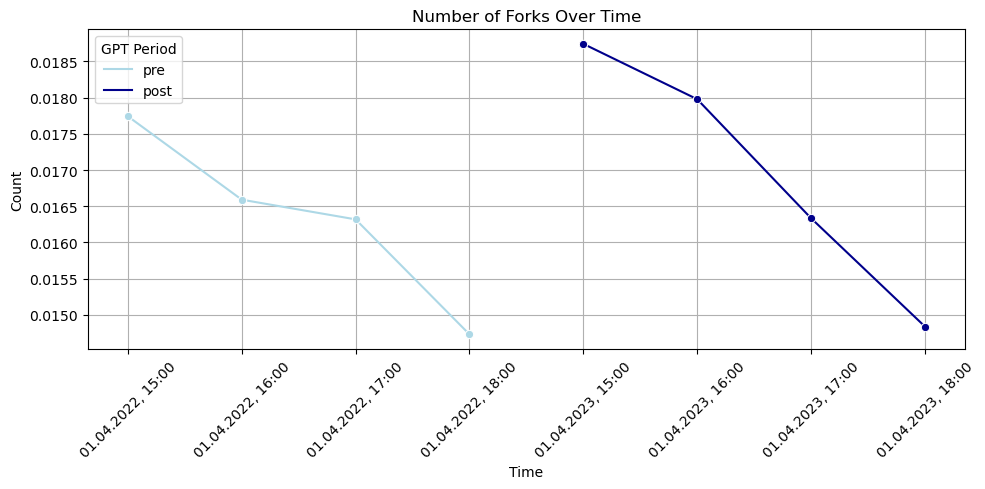

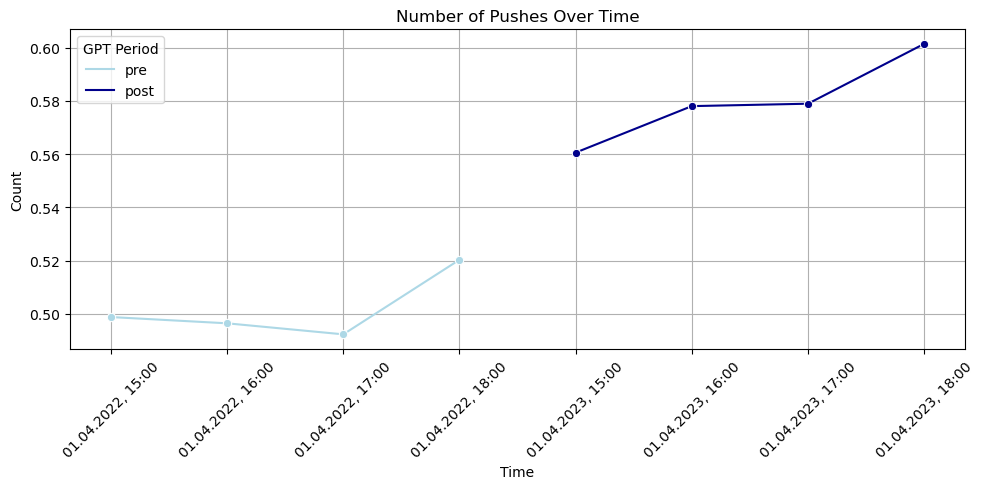

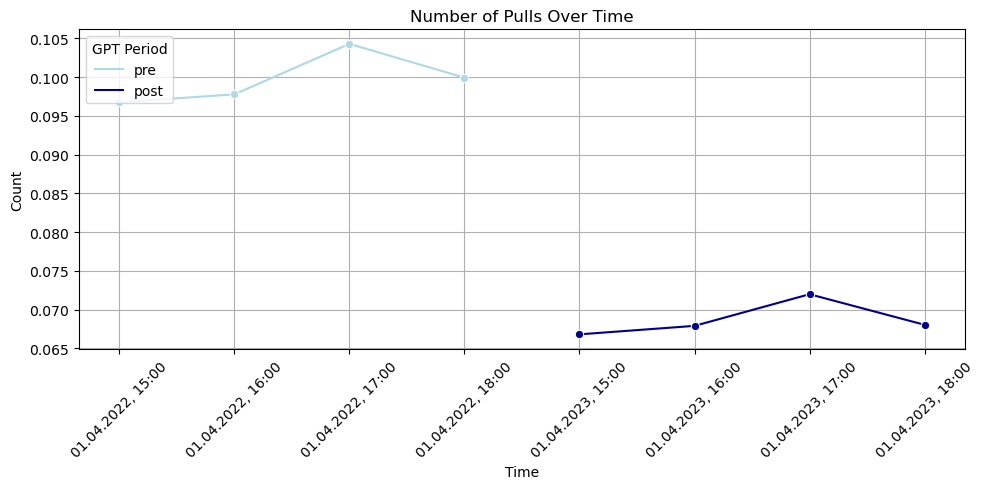

In [21]:
# Ensure 'time_id' is in the correct format
panel['time_id'] = pd.to_datetime(panel['time_id'], format='%d.%m.%Y, %H:%M').dt.strftime('%d.%m.%Y, %H:%M')

# Group data and calculate means
grouped = panel.groupby(['time_id', 'period']).agg({'is_fork': 'mean', 'is_push': 'mean', 'is_pull': 'mean'}).reset_index()

# Visualization setup
metrics_titles = [('is_fork', 'Number of Forks Over Time'), ('is_push', 'Number of Pushes Over Time'), ('is_pull', 'Number of Pulls Over Time')]
palette = {'pre': 'lightblue', 'post': 'darkblue'}

for metric, title in metrics_titles:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x='time_id', y=metric, hue='period', palette=palette, marker='o', data=grouped, sort=False)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.legend(title='GPT Period', loc='upper left')
    plt.show()

# 3. Parallel Trends Assumption

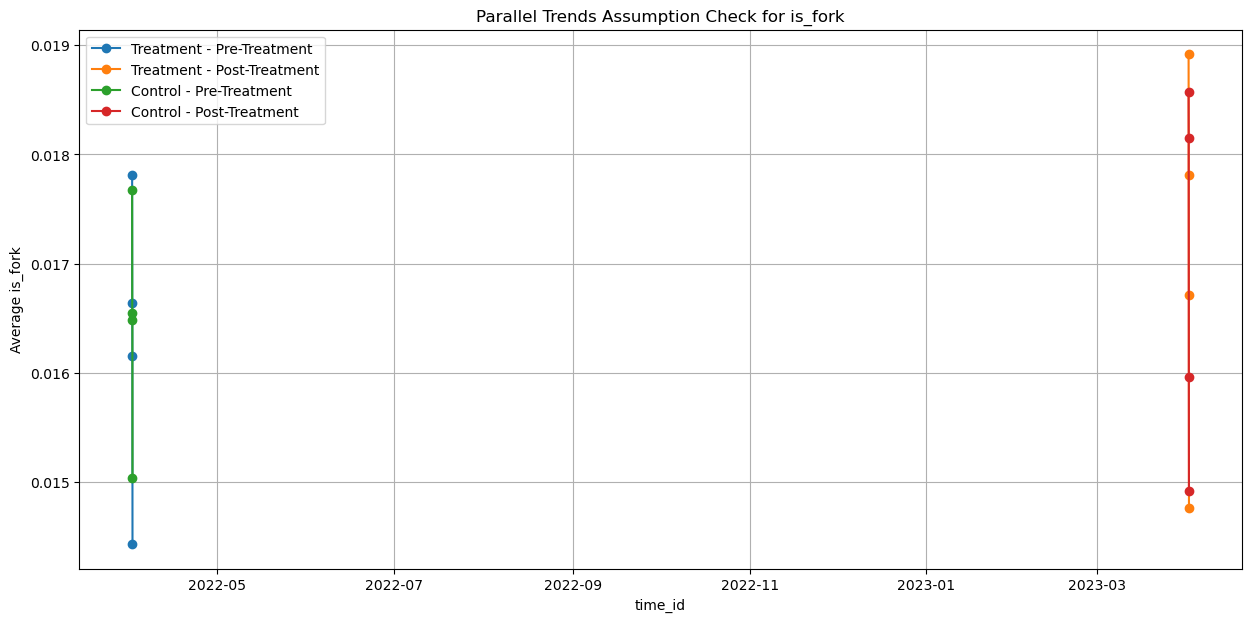

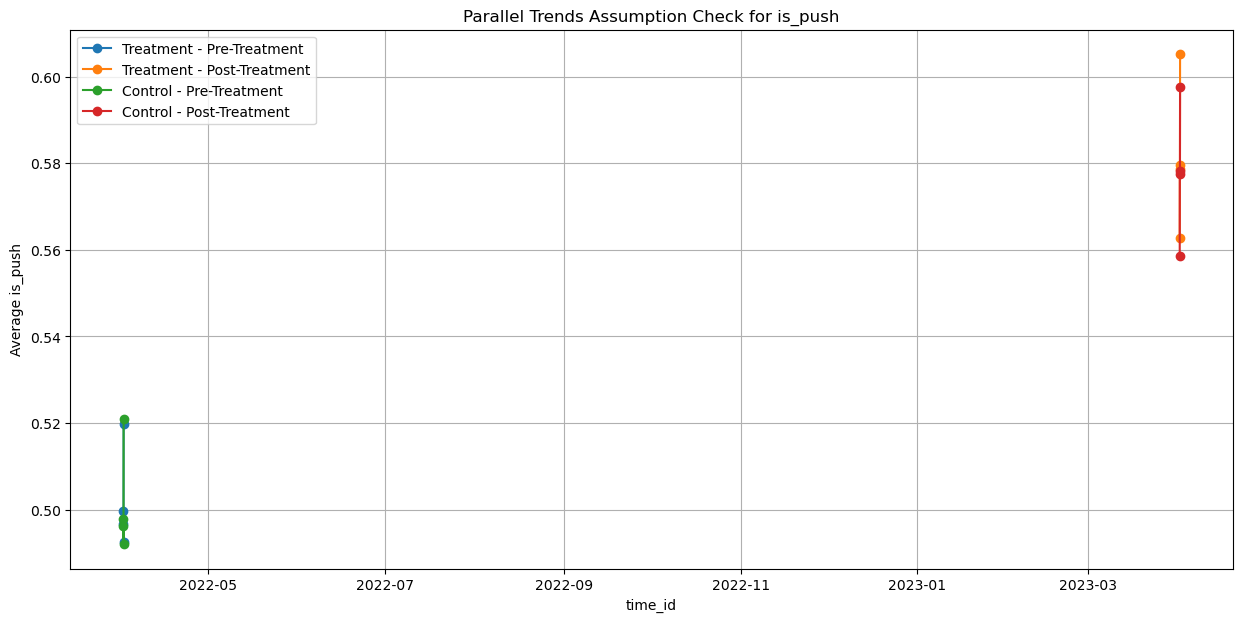

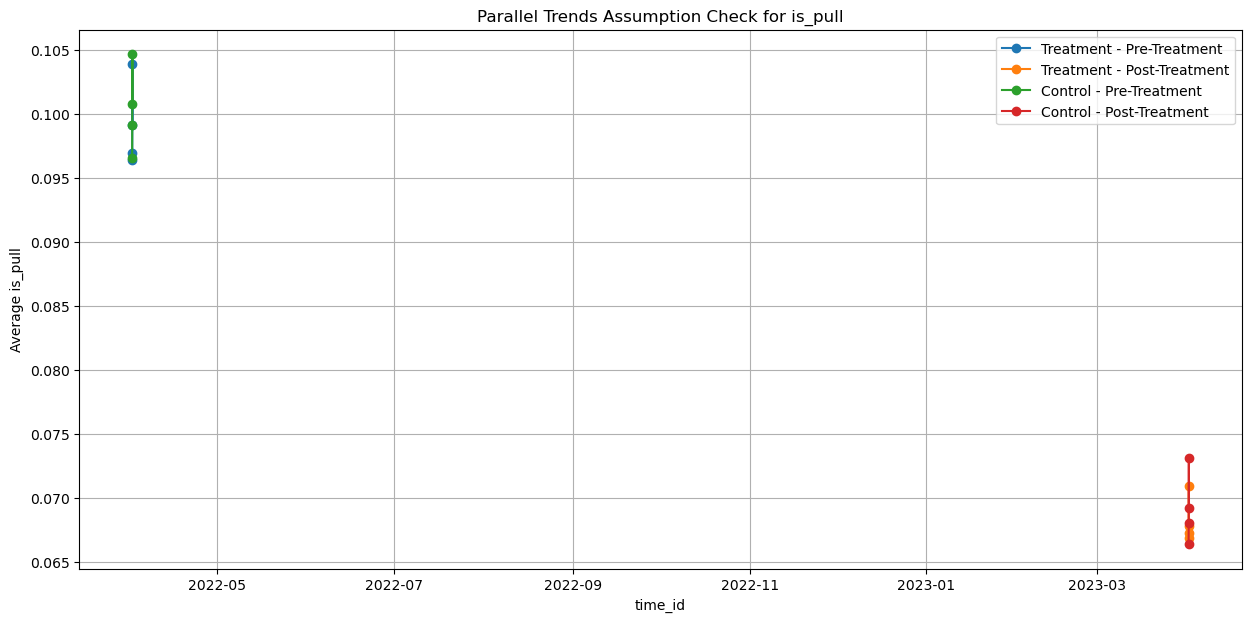

In [30]:
# Statistical Assumptions Check: Parallel Trends
def check_parallel_trends(panel_data, outcome_vars, time_var, treatment_var, period_var):
    """
    Function to plot the trends of outcome variables for treatment and control groups.
    
    Args:
    panel_data (DataFrame): The panel data containing all observations.
    outcome_vars (list): List of outcome variable names to check for parallel trends.
    time_var (str): Name of the time variable in the panel data.
    treatment_var (str): Name of the treatment indicator variable.
    period_var (str): Name of the period indicator variable (0 for pre-treatment, 1 for post-treatment).
    """
    # Ensure data is sorted by time
    panel_data = panel_data.sort_values(by=[time_var])
    
    for outcome in outcome_vars:
        plt.figure(figsize=(15, 7))
        
        # Loop through each level of treatment (0 and 1)
        for treatment in panel_data[treatment_var].unique():
            # Subset the data for the treatment and control groups
            subset = panel_data[panel_data[treatment_var] == treatment]
            
            # Aggregate data by time period
            agg_data = subset.groupby([time_var, period_var]).agg({outcome: 'mean'}).reset_index()
            
            # Plotting
            for period in agg_data[period_var].unique():
                period_data = agg_data[agg_data[period_var] == period]
                label = f"{'Control' if treatment == 0 else 'Treatment'} - {'Pre-Treatment' if period == 0 else 'Post-Treatment'}"
                plt.plot(period_data[time_var], period_data[outcome], marker='o', linestyle='-', label=label)
        
        plt.title(f'Parallel Trends Assumption Check for {outcome}')
        plt.xlabel(time_var)
        plt.ylabel(f'Average {outcome}')
        plt.legend()
        plt.grid(True)
        plt.show()

# Specify the variables
outcome_variables = ['is_fork', 'is_push', 'is_pull']  # add or remove based on your outcome metrics
time_variable = 'time_id'
treatment_variable = 'Treatment'
period_variable = 'period'

# Call the function with your panel data
check_parallel_trends(panel, outcome_variables, time_variable, treatment_variable, period_variable)

### Interpretation - what to look out for when looking at the graphs (once we use the full dataset)
- Pre-Treatment Trends: The lines for Italy and Germany should move in parallel, showing a similar trajectory
- Divergence Post-Treatment: If the treatment had an effect, the two lines might diverge post GPT
- Consistency Across Metrics: If the same trend is consistent across all metrics, there is stronger validation for the assumption

# 4.Calculate DiD Estimates & Fit Regressions

In [29]:
group_means = panel.groupby(['Treatment', 'period']).mean()

# Calculate the first differences and DiD estimator using the group_means directly
diff_control = group_means.loc[(0, 1)] - group_means.loc[(0, 0)]
diff_treatment = group_means.loc[(1, 1)] - group_means.loc[(1, 0)]
did_estimator = diff_treatment - diff_control

print("Calculated the Difference in Differences Estimator.")

# Check and print specific columns
columns_to_check = ['is_fork', 'is_push', 'is_pull']
did_estimator_selected = did_estimator.reindex(columns_to_check)
print(did_estimator_selected)

# Fit regressions for each outcome metric
panel['treat_post'] = panel['Treatment'] * panel['period']
outcomes = ['is_fork', 'is_push', 'is_pull']

for outcome in outcomes:
    model = smf.ols(f'{outcome} ~ Treatment + period + treat_post', data=panel).fit()
    print(f"Results for {outcome}:\n", model.summary(), "\n---\n")

C:\Users\Kim\AppData\Local\Temp\ipykernel_3172\749662436.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  group_means = panel.groupby(['Treatment', 'period']).mean()


Calculated the Difference in Differences Estimator.
is_fork    0.000318
is_push    0.003106
is_pull    0.000225
dtype: float64
Results for is_fork:
                             OLS Regression Results                            
Dep. Variable:                is_fork   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.716
Date:                Thu, 19 Oct 2023   Prob (F-statistic):             0.0431
Time:                        10:45:26   Log-Likelihood:             8.1795e+05
No. Observations:             1285782   AIC:                        -1.636e+06
Df Residuals:                 1285778   BIC:                        -1.636e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [

## Interpretation of DiD Estimates and significance levels
The DiD analysis indicates that the treatment had no statistically significant impact on the 'is_fork', 'is_push', and 'is_pull' metrics, suggesting that the observed changes in these behaviors cannot be attributed to the intervention under study (for this preliminary sample)

# (Outdated EDA)

## Calculate different metrics to measure collaboration on repository-level and store in new df 'repos'

In [ ]:
# Extracting repository name and id for easy grouping
commits['repo_name'] = commits['repo'].apply(lambda x: x['name'])
commits['repo_id'] = commits['repo'].apply(lambda x: x['id'])
commits['actor_login'] = commits['actor'].apply(lambda x: x['login'])

# Calculating metrics
grouped = commits.groupby(['repo_name', 'repo_id'])

forks_per_repo = grouped.apply(lambda x: (x['type'] == 'ForkEvent').sum())
push_per_repo = grouped.apply(lambda x: (x['type'] == 'PushEvent').sum())
pull_per_repo = grouped.apply(lambda x: (x['type'] == 'PullRequestEvent').sum())
unique_contributors_per_repo = grouped['actor_login'].nunique()
total_contributors_per_repo = grouped['actor_login'].size()

# Combining metrics into a new dataframe
repos = pd.DataFrame({
    'Forks': forks_per_repo,
    'Pushes': push_per_repo,
    'Pulls': pull_per_repo,
    'UniqueContributors': unique_contributors_per_repo,
    'TotalContributions': total_contributors_per_repo,
}).reset_index()
repos.head()

In [ ]:
repos.describe()

### Visualisations

In [ ]:
sns.set_theme(style="whitegrid")
metrics = ['Forks', 'Pushes', 'Pulls', 'UniqueContributors', 'TotalContributions']
for metric in metrics:
    plt.figure(figsize=(12, 6))
    value_counts = repos[metric].value_counts().sort_index()
    plt.scatter(value_counts.index, value_counts.values, alpha=0.5, color='navy')
    plt.title(f'Repositories Distribution by Number of {metric}', fontsize=20)
    plt.xlabel(f'Number of {metric} (in a Repository)', fontsize=20)
    plt.ylabel(f'Number of Repositories', fontsize=20)
    plt.grid(True)
    plt.tight_layout()
    plt.show()